# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


In [1]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
# add any additional libaries you need here


In [3]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [6]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<AxesSubplot:xlabel='category'>

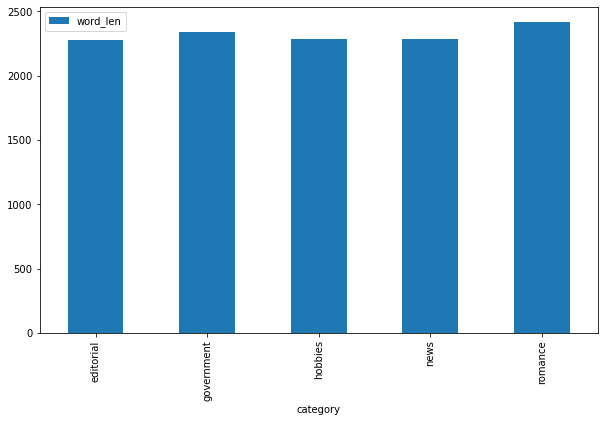

In [7]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [8]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(166, 4941)

In [9]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: Both dataframes hold a matrix of tokens. They both have a minimum threshold of 5 document appearances, and ignore words that appear in more than 70% of documents. More specifically, count_text_vectors is a matrix of vectors that represent number of article appearances. tfidf_text_vectors is a matrix of vectors that represent TF-IDF scores for each word.

See https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html and 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html and 
https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [10]:
nmf_text_model = NMF(n_components=5, random_state=314)
# some notes taken from Professor Marbut via Slack
# W will provide a list of probabilities that a document falls under a specific topic
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [11]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [12]:
# Your code here

# for reference/clarity (taken from Slack discussion): 
# 1) W_text_matrix is used to determine highest probability topic per document then 
# 2) display the topic-document relationship however you'd like

# let's take a quick look at the brown data
df.head()

,category,id,text,char_len,word_len
0,editorial,cb01,Assembly session brought much good The General...,12659,2200
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241


In [13]:
# let's see how the brown corpus has the categories distributed
df['category'].value_counts()

news          44
hobbies       36
government    30
romance       29
editorial     27
Name: category, dtype: int64

In [14]:
# now let's take a look at W_test_matrix
W_text_matrix_df = pd.DataFrame(W_text_matrix)
W_text_matrix_df.head()

,0,1,2,3,4
0,0.168337,0.000000,0.196650,0.0,0.028598
1,0.321769,0.000000,0.000000,0.0,0.000000
2,0.273861,0.040403,0.000000,0.0,0.001421
3,0.270374,0.000000,0.048464,0.0,0.000345
4,0.200523,0.002224,0.111485,0.0,0.017609


In [15]:
# each observation corresponds to the probability of that article (row) belonging
# to a certain topic (column)
# for consistency, we'll rename the columns to match
W_text_matrix_df.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']
W_text_matrix_df.head()

,Topic 00,Topic 01,Topic 02,Topic 03,Topic 04
0,0.168337,0.000000,0.196650,0.0,0.028598
1,0.321769,0.000000,0.000000,0.0,0.000000
2,0.273861,0.040403,0.000000,0.0,0.001421
3,0.270374,0.000000,0.048464,0.0,0.000345
4,0.200523,0.002224,0.111485,0.0,0.017609


In [16]:
# let's add a column in the brown corpus identifying the topic with the highest probability
# see https://stackoverflow.com/questions/29919306/find-the-column-name-which-has-the-maximum-value-for-each-row 
# for reference for cleaner code
df['topic'] = W_text_matrix_df.idxmax(axis=1)
df.head()

,category,id,text,char_len,word_len,topic
0,editorial,cb01,Assembly session brought much good The General...,12659,2200,Topic 02
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234,Topic 00
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244,Topic 00
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230,Topic 00
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241,Topic 00


In [17]:
# let's isolate our variables of interest
df2 = df[['category', 'topic']].copy()
df2.head()

,category,topic
0,editorial,Topic 02
1,editorial,Topic 00
2,editorial,Topic 00
3,editorial,Topic 00
4,editorial,Topic 00


In [18]:
# we'll use dataframe.pivot_table to see category vs topic distribution
# aggfunc = len will count the topics
# see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot_table.html
df_pivot = df2.pivot_table(index='category', columns=['topic'], aggfunc=len)
df_pivot

topic,Topic 00,Topic 01,Topic 02,Topic 03,Topic 04
category,,,,,
editorial,20.0,4.0,2.0,NaN,1.0
government,4.0,NaN,26.0,NaN,NaN
hobbies,NaN,8.0,26.0,1.0,1.0
news,8.0,NaN,11.0,17.0,8.0
romance,NaN,29.0,NaN,NaN,NaN


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: Compared to the original Brown categories, it appears that Topic 00 with keywords such as "mr", "president", and "kennedy" contains articles classified largely as editorials, followed by news and government respectively. This appears to align well with the Brown category, as the keywords appear affiliated with politics.

Topic 01 with keywords such as "said", "thought", and "man" contains articles classified largely as romance. This is followed by hobbies and editorials respectively. Assuming that the keywords allude to opinion pieces, perhaps tabloids and gossip columns, then the categorization of this topic largely as romance seems fitting.

Topic 02 with keywords such as "state", "development", "sales", "program", and "tax" contains articles classified evenly as government and hobbies. This is followed by classifications as news and editorial. A larger amount of articles appear to fall under Topic 02, accounting for nearly a third of all article topics.

Topic 03 with keywords such as "mrs", "mr", "said", and "miss" contains articles almost unanimously categorized as news except for the one article categorized as hobbies. This may be related to the usage of more formal address of individuals in news.

Topic 04 with keywords such as "game", "league", and "ball" is the least popular topic with only ten total articles classified under Topic 04. Of these ten, eight were of the news category, and editorial and hobbies had one article each. The keywords appear to be related to sports, so the categorization and topic distribution may be related to how a sports article is written.

Overall, the first three topics have a majority of the articles classified under them, with Topic 03 and 04 underrepresented when compared to the categorization in the original Brown categories.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [19]:
# Your code here

# code taken largely from the BTAP repo
# we'll be using tfidf_text_vectors that was previously defined
# from the BTAP repo, we've updated n_components = 5 to stay consistent
svd_text_model = TruncatedSVD(n_components = 5, random_state=314)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

In [20]:
# we'll use the W_svd_text_matrix to classify the topics of an article
# first, let's put the matrix into a dataframe
W_svd_text_matrix_df = pd.DataFrame(W_svd_text_matrix)

# we'll define the columns as topics
W_svd_text_matrix_df.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']

# let's define our svd dataframe and add our topic classification
df3 = df[['category']].copy()
# once again, see # see https://stackoverflow.com/questions/29919306/find-the-column-name-which-has-the-maximum-value-for-each-row 
# for reference of dataframe.idmax usage
df3['topic'] = W_svd_text_matrix_df.idxmax(axis=1)
df3.head()

,category,topic
0,editorial,Topic 00
1,editorial,Topic 00
2,editorial,Topic 00
3,editorial,Topic 00
4,editorial,Topic 00


In [21]:
# we'll use dataframe.pivot_table to see category vs topic distribution
# aggfunc = len will count the topics
# see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot_table.html
svd_pivot = df3.pivot_table(index='category', columns=['topic'], aggfunc=len)
svd_pivot

topic,Topic 00,Topic 01,Topic 03,Topic 04
category,,,,
editorial,27.0,NaN,NaN,NaN
government,30.0,NaN,NaN,NaN
hobbies,36.0,NaN,NaN,NaN
news,34.0,NaN,3.0,7.0
romance,21.0,8.0,NaN,NaN


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: Where there used to be some distribution of the articles under various topics, the LSA model has categorized the articles largely under Topic 00. Eight articles were classified under Topic 01, seven articles were classified under Topic 04, and only three articles were classified under Topic 03. No articles were classified under Topic 02.

Overall, it would appear that the LSA model was not able to classify the articles as well as nearly all of the articles were classified under one category, Topic 00. 

In [22]:
# call display_topics on your model
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: Compared to NMF, the display topics output for SVD share more keywords between the top five topics. In addition, the percent frequency of the keyword in each topic is distributed in a way that it would be near impossible for articles to be classified under topics other than Topic 00. This is due to the high percent frequency needed for all other topics, which may only occur if the article is not lexically complex or if the article contains a very small number of words.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [23]:
# Fit your LDA model here

# once again, this is taken largely from the BTAP repo
# n_components has been modified to be consistent with the rest of the notebook, resulting in 5 topics
lda_text_model = LatentDirichletAllocation(n_components = 5, random_state=314)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [24]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


In [25]:
# tallying of brown corpus categories with our LDA model topics to help answer questions

# we'll use the W_lda_text_matrix to classify the topics of an article
# first, let's put the matrix into a dataframe
W_lda_text_matrix_df = pd.DataFrame(W_lda_text_matrix)

# we'll define the columns as topics
W_lda_text_matrix_df.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']

# let's define our svd dataframe and add our topic classification
df4 = df[['category']].copy()
# once again, see # see https://stackoverflow.com/questions/29919306/find-the-column-name-which-has-the-maximum-value-for-each-row 
# for reference of dataframe.idmax usage
df4['topic'] = W_lda_text_matrix_df.idxmax(axis=1)
df4.head()

,category,topic
0,editorial,Topic 02
1,editorial,Topic 02
2,editorial,Topic 02
3,editorial,Topic 02
4,editorial,Topic 02


In [26]:
# we'll use dataframe.pivot_table to see category vs topic distribution
# aggfunc = len will count the topics
# see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot_table.html
lda_pivot = df4.pivot_table(index='category', columns=['topic'], aggfunc=len)
lda_pivot

topic,Topic 00,Topic 01,Topic 02,Topic 03,Topic 04
category,,,,,
editorial,3.0,1.0,21.0,2.0,NaN
government,1.0,12.0,3.0,4.0,10.0
hobbies,11.0,9.0,2.0,8.0,6.0
news,4.0,3.0,32.0,3.0,2.0
romance,28.0,NaN,1.0,NaN,NaN


Q: What inference do you draw from the displayed topics for your LDA model? 

A: Looking at the percent frequency of the keywords of each topic, I can assume that LDA will perform better than the LSA model in categorizing the articles under more varied topics. However, looking at the keywords for LDA model topics, there does not appear to be as clear of an explanation for the separation of topics. Compared to NMF, the LDA model may contain a lot of mixing of Brown corpus categories with various LDA model topics.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Our five-topic LDA model has categorized more than half of the articles within Topic 00 and 02, which is a different distribution compared to the fairly even category distribution of the original Brown corpus. Perhaps due to the similar keywords in the topics, aside from the original "romance" and "editorial" categories of the Brown corpus, the rest of the articles in the original Brown corpus categories have bee nspread amongst the five LDA topics.

In [27]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [28]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: Within the salient terms graph, the estimated term frequency is always more gradual and accounts for a much smaller term frequency compared to the overall term frequency. However, in the fourth and fifth topic, we can see that the estimated term frequency starts to deviate and doesn't always correspond to the overall term frequency, which is more the case with the first three topics.

With the principal component scatterplot, we can see that the first three topics' thirty most relevant terms account for about 75% of the total tokens. 